# CS x476 - Fall 2021
# Project 4: Local Feature Matching

## Brief
* Due: Friday, 11/05/2021, 11:59PM ??

* Hand-in: through Gradescope
* Required files:
  * `<your_gt_username>.zip`
  * `<yout_gt_username>.pdf`

All projects in this course will be done with these jupyter notebooks. These are convenient ways for you to easily interact with your code. A notebook contains many blocks of code, each of which can be run independently.

There are multiple ways that you can run a cell:
1. Run the current cell, and stay in the current cell
  * `ctrl+enter` on Windows and Linux
  * `cmd+enter` on MacOS
2. Run the current cell, move to the next cell:
  * `shift+enter`
  * click the "Run" button in the tool bar

Table of Contents
Section 1: Harris Corner Detector  

TO-DOs:
1. compute_image_gradients()
2. second_moments() and get_gaussian_kernel_2D_pytorch()
3. compute_harris_response_map()
4. maxpool_numpy()
5. remove_bordget_harris_interest_points()  

Section 2: SIFT  
TO-DOs:
1. get_magnitudes_and_orientations()
2. get_gradient_histogram_vec_from_patch()
3. get_feat_vec()
4. get_SIFT_descriptors()  

Section 3: Feature Matching
TO-DOs
1. compute_feature_distances() - provide SIFT, show output image, note they use sift descriptors
2. match_features_ratio_test()

Section 4: Extra Credit

## Set up
The below cell loads and displays images on which we will try to match features. Uncomment different images to produce to run on different pairs.

In [42]:
%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import torch

from utils import load_image, PIL_resize, rgb2gray, normalize_img, verify
from IPython.core.debugger import set_trace

# CRC
# image1 = load_image('../data/1a_crc.jpg')
# image2 = load_image('../data/1b_crc.jpg')


# Klaus
image1 = load_image('../data/2a_klaus.jpg')
image2 = load_image('../data/2b_klaus.jpg')

scale_factor = 0.5
image1 = PIL_resize(image1, (int(image1.shape[1]*scale_factor), int(image1.shape[0]*scale_factor)))
image2 = PIL_resize(image2, (int(image2.shape[1]*scale_factor), int(image2.shape[0]*scale_factor)))
image1_bw = rgb2gray(image1)
image2_bw = rgb2gray(image2)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(image1)
plt.subplot(1,2,2)
plt.imshow(image2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


# Part 1: Harris Corner Detector 


### TO-DO 1
 Implement `compute_image_gradients()` in `student_code.py`
 The Harris corner detector and SIFT rely heavily upon image gradient information. 

In [43]:
from student_code import compute_image_gradients
from cv_proj4_unit_tests.test_part1_harris_corner import test_compute_image_gradients
import torch

print('compute_image_gradients(): ', verify(test_compute_image_gradients))

plt.figure(figsize=(10,5))
plt.axis('off')


Ix, Iy = compute_image_gradients(torch.from_numpy(image1_bw))
Ix = Ix.numpy()
Iy = Iy.numpy()
gradient_magnitudes = np.sqrt(Ix**2 + Iy**2)
gradient_magnitudes = normalize_img(gradient_magnitudes)
plt.subplot(1,2,1)
plt.title(r'$\sqrt{I_x^2 + I_y^2}$')
plt.imshow( (gradient_magnitudes*255).astype(np.uint8))

torch.from_numpy(image2_bw)
Ix, Iy = compute_image_gradients(torch.from_numpy(image2_bw))
Ix = Ix.numpy()
Iy = Iy.numpy()
gradient_magnitudes = np.sqrt(Ix**2 + Iy**2)
gradient_magnitudes = normalize_img(gradient_magnitudes)
plt.subplot(1,2,2)
plt.title(r'$\sqrt{I_x^2 + I_y^2}$')
plt.imshow( (gradient_magnitudes*255).astype(np.uint8))


compute_image_gradients():  "Correct"


<IPython.core.display.Javascript object>

### TO-DO 2
Implement `get_gaussian_kernel_2D_pytorch` and `second_moments()` in `student_code.py`

We'll now compute the second moments $s_x^2, s_y^2, s_x s_y$ at each pixel, which aggregates gradient information in local neighborhoods. We'll use a 2d Gaussian filter to aggregate:

In [81]:
from student_code import second_moments
import torch
from cv_proj4_unit_tests.test_part1_harris_corner import (
    test_get_gaussian_kernel_2D_pytorch_peak,
    test_get_gaussian_kernel_2D_pytorch_sumsto1,
    test_get_gaussian_kernel_2D_pytorch,
    test_second_moments
)

print('get_gaussian_kernel_2D_pytorch_peak():', verify(test_get_gaussian_kernel_2D_pytorch_peak))
print('get_gaussian_kernel_2D_pytorch_sumsto1():', verify(test_get_gaussian_kernel_2D_pytorch_sumsto1))
print('get_gaussian_kernel_2D_pytorch():', verify(test_get_gaussian_kernel_2D_pytorch))
print('second_moments():', verify(test_second_moments))

sx2, sy2, sxsy = second_moments(torch.from_numpy(image1_bw), ksize = 7, sigma = 10)
sx2 = sx2.numpy()
sy2 = sy2.numpy()
sxsy = sxsy.numpy()


get_gaussian_kernel_2D_pytorch_peak(): "Correct"
get_gaussian_kernel_2D_pytorch_sumsto1(): "Correct"
get_gaussian_kernel_2D_pytorch(): "Correct"
second_moments(): "Correct"


<IPython.core.display.Javascript object>


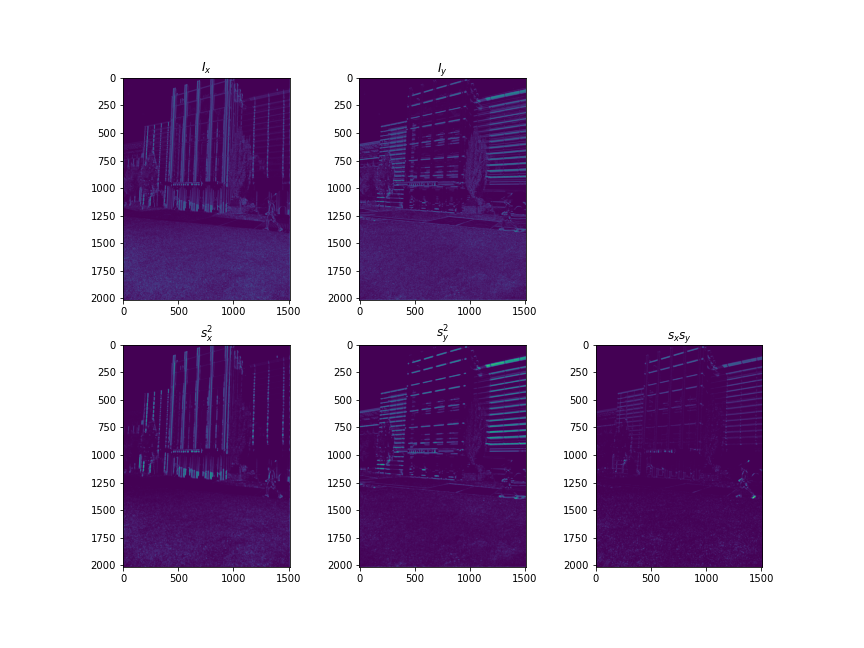

In [82]:
from utils import normalize_img

plt.figure(figsize=(12,9))
Ix, Iy = compute_image_gradients(torch.from_numpy(image1_bw))
Ix = Ix.numpy()
Iy = Iy.numpy()
plt.subplot(2,3,1); plt.title(r'$I_x$')
plt.imshow( (normalize_img(np.abs(Ix))*255).astype(np.uint8))
plt.subplot(2,3,2); plt.title(r'$I_y$')
plt.imshow( (normalize_img(np.abs(Iy))*255).astype(np.uint8))

plt.subplot(2,3,4)
plt.title(r'$s_x^2$')
plt.imshow( (normalize_img(np.abs(sx2))*255).astype(np.uint8))

plt.subplot(2,3,5)
plt.title(r'$s_y^2$')
plt.imshow( (normalize_img(np.abs(sy2))*255).astype(np.uint8))

plt.subplot(2,3,6)
plt.title(r'$s_xs_y$')
plt.imshow( (normalize_img(np.abs(sxsy))*255).astype(np.uint8))

### TO-DO 3

Implement `compute_harris_response_map()` in `student_code.py`

Note that $s_xs_y$ is highest where there are both strong x-direction and y-direction gradients (corners and the central rose window).

We'll now use these second moments to compute a "cornerness score" -- a corner response map -- as a function of these image gradients.

compute_harris_response_map():  "Correct"


<IPython.core.display.Javascript object>


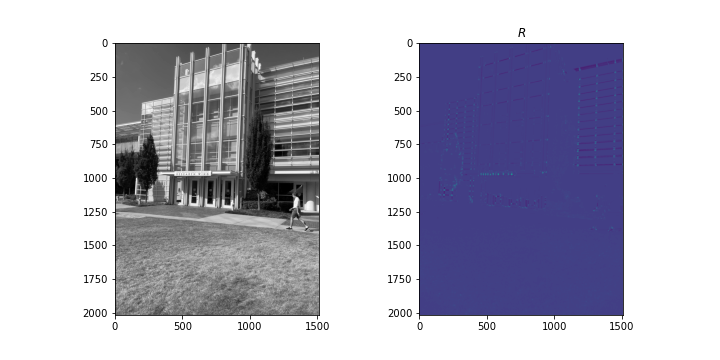

In [83]:
from student_code import compute_harris_response_map
from cv_proj4_unit_tests.test_part1_harris_corner import test_compute_harris_response_map

print('compute_harris_response_map(): ', verify(test_compute_harris_response_map))

R = compute_harris_response_map(torch.from_numpy(image1_bw))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image1_bw, cmap='gray')
plt.subplot(1,2,2)
plt.title(r'$R$')
plt.imshow(R)

### TO-DO 4
Implement `maxpool_numpy()` and `nms_maxpool_pytorch()` in `student_code.py`
In order to find local maxima in the 2d response max we can simply pick a local maximum over some window size (u, v). This non-maximum suppression can be achieved using max-pooling. You can see a visualization of how this process works below. On the left is the image, on the right is the result of the max-pooling. The cell below will run your own code on the same example.
![image and maxpool](notebookimages/maxpoolexample.png "Image on left, max-pool result on right")


In [ ]:
from student_code import maxpool_numpy
from cv_proj4_unit_tests.test_part1_harris_corner import test_maxpool_numpy, test_nms_maxpool_pytorch
from utils import verify

print('maxpool_numpy(): ', verify(test_maxpool_numpy))

toy_response_map = np.array(
[
    [1,2,2,1,2],
    [1,6,2,1,1],
    [2,2,1,1,1],
    [1,1,1,7,1],
    [1,1,1,1,1]
]).astype(np.float32)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(toy_response_map.astype(np.uint8))

plt.subplot(1,2,2)

maxpooled_image = maxpool_numpy(torch.from_numpy(toy_response_map), ksize=3)
maxpooled_image = maxpooled_image.numpy()

plt.imshow(maxpooled_image.astype(np.uint8))

Given a simple 5x5 grid of response scores, non-max suppression will allow us to choose values that are local maxima. If we request the top $k=2$ responses of the toy response grid above, we should get (1,1) and (3,3)

In [ ]:
from student_code import nms_maxpool_pytorch

print('nms_maxpool_pytorch(): ', verify(test_nms_maxpool_pytorch))

x_coords, y_coords, confidences = nms_maxpool_pytorch(torch.from_numpy(toy_response_map), k=2, ksize=3)
x_coords = x_coords.numpy()
y_coords = y_coords.numpy()
confidences = confidences.numpy()
print('Coordinates of local maxima:')
for x, y, c in zip(x_coords, y_coords, confidences):
    print(f'\tAt {x},{y}, local maximum w/ confidence={c:.2f}')

### TO-DO 5
Implement `remove_border_vals()` and `get_harris_interest_points()` function in `student_code.py` to detect 'interesting' points in the images. The below cell will run unit tests on your implementation.

In [ ]:
from cv_proj4_unit_tests.test_part1_harris_corner import test_get_harris_interest_points, test_remove_border_vals

print('test_remove_border_vals(): ', verify(test_remove_border_vals))

print('get_harris_interest_points()', verify(test_get_harris_interest_points))

Run the cell below to see the interest points of your images.

In [ ]:
import copy
from student_code import get_harris_interest_points
from utils import show_interest_points
import torch

num_interest_points = 2500
X1, Y1, _ = get_harris_interest_points( torch.from_numpy(copy.deepcopy(image1_bw)), num_interest_points)
X2, Y2, _ = get_harris_interest_points( torch.from_numpy(copy.deepcopy(image2_bw)), num_interest_points)
X1 = X1.numpy()
X2 = X2.numpy()
Y1 = Y1.numpy()
Y2 = Y2.numpy()

num_pts_to_visualize = 300
# Visualize the interest points
rendered_img1 = show_interest_points(image1, X1[:num_pts_to_visualize], Y1[:num_pts_to_visualize])
rendered_img2 = show_interest_points(image2, X2[:num_pts_to_visualize], Y2[:num_pts_to_visualize])
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(rendered_img1)
plt.subplot(1,2,2); plt.imshow(rendered_img2)
print(f'{len(X1)} corners in image 1, {len(X2)} corners in image 2')

# Part 2: Sift Feature Descriptor
SIFT relies upon computing the magnitudes and orientations of image gradients, and then computing weighted histograms.

### TO-DO 6

implement `get_magnitudes_and_orientations()` in `student_code.py`. These will be used to calculate the gradient histogram vectors for each patch. Test your implementation below.

In [ ]:
from cv_proj4_unit_tests.test_part2_sift_descriptor import (
    test_get_magnitudes_and_orientations,
    test_get_gradient_histogram_vec_from_patch
)
print('get_magnitudes_and_orientations:', verify(test_get_magnitudes_and_orientations))

### TO-DO 7
implement `get_gradient_histogram_vec_from_patch()` in `student_code.py`.  This function takes in (16,16) arrays representing the magnitudes and orientations of a given patch. For each 4x4 possible "cell" in the 16x16 patch, compute the histogram of the distribution of gradients in 8 orientations. 


In [ ]:
print('get_gradient_histogram_vec_from_patch():', verify(test_get_gradient_histogram_vec_from_patch))

### TO-DO 8
Implement `get_feat_vec()` in `student_code.py`.  This function takes in an interest point and the magnitudes and orientations of the entire image, then calls the previously written function to get the gradient histogram, passing in the appropriate section of the magnitudes and orientations. Finally, it should normalize the returned gradient histogram (divide by the norm) then square root it as described in [here](https://www.robots.ox.ac.uk/~vgg/publications/2012/Arandjelovic12/arandjelovic12.pdf) for a performance boost.


In [ ]:
from cv_proj4_unit_tests.test_part2_sift_descriptor import test_get_feat_vec
print(verify(test_get_feat_vec))

### TO-DO 9
Implement `get_SIFT_descriptors()` in `student_code.py`. This function is passed an image and an array of x values of interest points and y values of interest points (`compute_image_gradients()`). It should first compute the gradients (Ix and Iy) of the image(`get_magnitudes_and_orientations()`), then use these to get the magnitude and orientation at each point. Then, for each x, y pair get the feature vector around it (`get_feat_vec()`).  


In [ ]:
from cv_proj4_unit_tests.test_part2_sift_descriptor import test_get_SIFT_descriptors
print(verify(test_get_SIFT_descriptors))

In [ ]:
from student_code import get_SIFT_descriptors
from utils import cheat_interest_points

import time
start = time.time()

image1_features = get_SIFT_descriptors(torch.from_numpy(image1_bw), torch.from_numpy(X1), torch.from_numpy(Y1))
image2_features = get_SIFT_descriptors(torch.from_numpy(image2_bw), torch.from_numpy(X2), torch.from_numpy(Y2))
image1_features = image1_features.numpy()
image2_features = image2_features.numpy()
end = time.time()
duration = end - start
print(f'SIFT took {duration} sec.')

# visualize what the values of the first 200 SIFT feature vectors look like (should not be identical or all black)
plt.figure(); plt.subplot(1,2,1); plt.imshow(image1_features[:200])

# Part 3: Match features

Now that we have implemented our SIFT descriptors, we can start trying to match features between images!

### TO-DO 10

Implement `compute_feature_distances()` in `student_code.py`. 

In [ ]:
#test your feature matching implementation
from cv_proj4_unit_tests.test_part3_feature_matching import (
    test_match_features_ratio_test,
    test_compute_feature_distances_2d,
    test_compute_feature_distances_10d
)
print('compute_feature_distances (2d):', verify(test_compute_feature_distances_2d))
print('compute_feature_distances (10d):', verify(test_compute_feature_distances_10d))
print('match_features_ratio_test:', verify(test_match_features_ratio_test))


### TODO - 11
Implement the ratio test show below in `match_features_ratio_test` in `student_code.py`. Set a threshold for NNDR (.75 is a decent baseline). 
$||D_A - D_B||$ is distance between Descriptor A and its closest match. $||D_A - D_C||$ is distance between Descriptor A and its second closest match. 

![ratio test equation](notebookimages/ratiotest.PNG)


In [ ]:
from student_code import match_features_ratio_test

matches, confidences = match_features_ratio_test(torch.from_numpy(image1_features), torch.from_numpy(image2_features))
matches = matches.numpy()
confidences = confidences.numpy()
print('{:d} matches from {:d} corners'.format(len(matches), len(X1)))

## Visualization

You might want to set 'num_pts_to_visualize' to some constant (e.g. 30) once you start detecting hundreds of interest points, otherwise things might get too cluttered. You could also threshold based on confidence.  
  
There are two visualization functions below. You can comment out one of both of them if you prefer. An example output you can compare against is provided below (yours may look different - that is okay), for the Klaus image pair with `num_pts_to_visualize` set to 30. If you are not confident in your own implementation of part 2, we have provided the features for image 1 and 2 of the CRC and Klaus so you can test your feature matching implementation. Note that you will need part 2 to be working in order to do the 4476 Extra Credit/6476 Part 4.
![Example visualization](notebookimages/crcOutput30.png "Example visualization")

In [ ]:
from utils import show_correspondence_circles, show_correspondence_lines
import os
os.makedirs('../results', exist_ok=True)

# uncomment if you are not confident in your SIFT implementation
# CRC
# image1_features = np.load(open('image1featurescrc', 'rb'))
# image2_features = np.load(open('image2featurescrc', 'rb'))
# Klaus
#image1_features = np.load(open('image1featuresklaus', 'rb'))
#image2_features = np.load(open('image1featuresklaus', 'rb'))

matches, confidences = match_features_ratio_test(torch.from_numpy(image1_features), torch.from_numpy(image2_features))
matches = matches.numpy()
confidences = confidences.numpy()
print('{:d} matches from {:d} corners'.format(len(matches), len(X1)))

# num_pts_to_visualize = len(matches)
num_pts_to_visualize = 30
c1 = show_correspondence_circles(
    image1,
    image2,
    X1[matches[:num_pts_to_visualize, 0]],
    Y1[matches[:num_pts_to_visualize, 0]],
    X2[matches[:num_pts_to_visualize, 1]],
    Y2[matches[:num_pts_to_visualize, 1]]
)
plt.figure(figsize=(10,5)); plt.imshow(c1)
plt.savefig('../results/vis_circles.jpg', dpi=1000)
c2 = show_correspondence_lines(
    image1,
    image2,
    X1[matches[:num_pts_to_visualize, 0]],
    Y1[matches[:num_pts_to_visualize, 0]],
    X2[matches[:num_pts_to_visualize, 1]],
    Y2[matches[:num_pts_to_visualize, 1]]
)
plt.figure(figsize=(10,5)); plt.imshow(c2)
plt.savefig('../results/vis_lines.jpg', dpi=1000)

# 4476 Extra Credit / 6476 Section 4

Take your own pictures of the same building from different locations, and run them through this notebook. Paste the results in the report, and answer the corresponding questions. Have fun and get creative!